<a href="https://colab.research.google.com/github/CyreMoonlord/ImageSort_wTransferLearning/blob/main/TransferLearning_Boosted_Image_Sorter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Summary

**Summary:**


Using machine learning to sort images has become a crucial part of modern image centered workflows. For large studios the volume of available images makes it easy to train custom models, but what about small and medium sized operations? By leveraging pretrained models available for free using transfer learning, then training for custom classes with a minimal set of images it should be possible to achieve accurate classification.



The proposal can be found here.
(https:// [Full Proposal](https://docs.google.com/document/d/1IU5sUlYeLN8nuspWntZnnk79pUgC4p0Wvn8gXydZB1k/edit?usp=sharing))

# Setup

## Import Libraries

In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from os.path import isfile
import numpy as np
from google.colab import files
from keras.preprocessing import image

## Function for reseting file structure

In [ ]:
def deletinator(folder):
  import os, shutil
  for filename in os.listdir(folder):
      file_path = os.path.join(folder, filename)
      try:
          if os.path.isfile(file_path) or os.path.islink(file_path):
              os.unlink(file_path)
          elif os.path.isdir(file_path):
              shutil.rmtree(file_path)
      except Exception as e:
          print('Failed to delete %s. Reason: %s' % (file_path, e))

In [ ]:
base_dir = '/content/ImageSets'
train_dir = '/content/train'
test_dir = '/content/test'
deletinator(train_dir)
deletinator(test_dir)
deletinator(base_dir)
os.rmdir(train_dir)
os.rmdir(test_dir)
os.rmdir(base_dir)

## Create the respective directories

The script is set up to use images sorted into folders as input. 

A base folder named **ImagesSets** containing a folder named for each custom class. At least two classes are required. 

The script is written for color images(RGB), sized to 200x200 pixels.

In [ ]:
#Unzip Image Set
local_zip = '/content/ImageSets.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()


In [ ]:
base_dir = '/content/ImageSets'
dir = next(os.walk(base_dir))

os.mkdir('/content/train')
os.mkdir('/content/test')

train_dir = '/content/train'
test_dir = '/content/test'

## Setting up Training and Testing directories

In [ ]:
#for testing sample sizes
sample_size = 800

train_dirs = []
test_dirs = []
classnames_list = []
for i in range (len(dir[1])):
  os.mkdir(os.path.join(train_dir, dir[1][i]))
  os.mkdir(os.path.join(test_dir, dir[1][i]))
  train_dirs.append(os.path.join(train_dir, dir[1][i]))
  test_dirs.append(os.path.join(test_dir, dir[1][i]))
  classnames_list.append(dir[1][i]) 
  x = 0
  while x < 200:
    randomfile = random.choice(os.listdir(os.path.join(base_dir, dir[1][i])))
    os.rename(os.path.join(base_dir, dir[1][i],randomfile),(os.path.join(test_dir, dir[1][i],randomfile)))
    x+=1
  x = 0
  while x < sample_size:
    randomfile = random.choice(os.listdir(os.path.join(base_dir, dir[1][i])))
    os.rename(os.path.join(base_dir, dir[1][i],randomfile),(os.path.join(train_dir, dir[1][i],randomfile)))
    x+=1

x = 0
classnames = {}
for c in sorted(classnames_list):
  classnames[x] = c
  x+=1


In [ ]:
#For everything in the folder
'''
train_dirs = []
test_dirs = []
classnames_list = []
for i in range (len(dir[1])):
  os.mkdir(os.path.join(train_dir, dir[1][i]))
  os.mkdir(os.path.join(test_dir, dir[1][i]))
  train_dirs.append(os.path.join(train_dir, dir[1][i]))
  test_dirs.append(os.path.join(test_dir, dir[1][i]))
  classnames_list.append(dir[1][i]) 
  x = 0
  while x < 200:
    randomfile = random.choice(os.listdir(os.path.join(base_dir, dir[1][i])))
    os.rename(os.path.join(base_dir, dir[1][i],randomfile),(os.path.join(test_dir, dir[1][i],randomfile)))
    x+=1
  x = 0    
  file_balance = [f for f in os.listdir(os.path.join(base_dir, dir[1][i])) if isfile(os.path.join(base_dir, dir[1][i], f))]
  for f in file_balance:
    os.rename(os.path.join(base_dir, dir[1][i],f),os.path.join(train_dir, dir[1][i],f))

x = 0
classnames = {}
for c in sorted(classnames_list):
  classnames[x] = c
  x+=1

'''

## Example Images from each Class

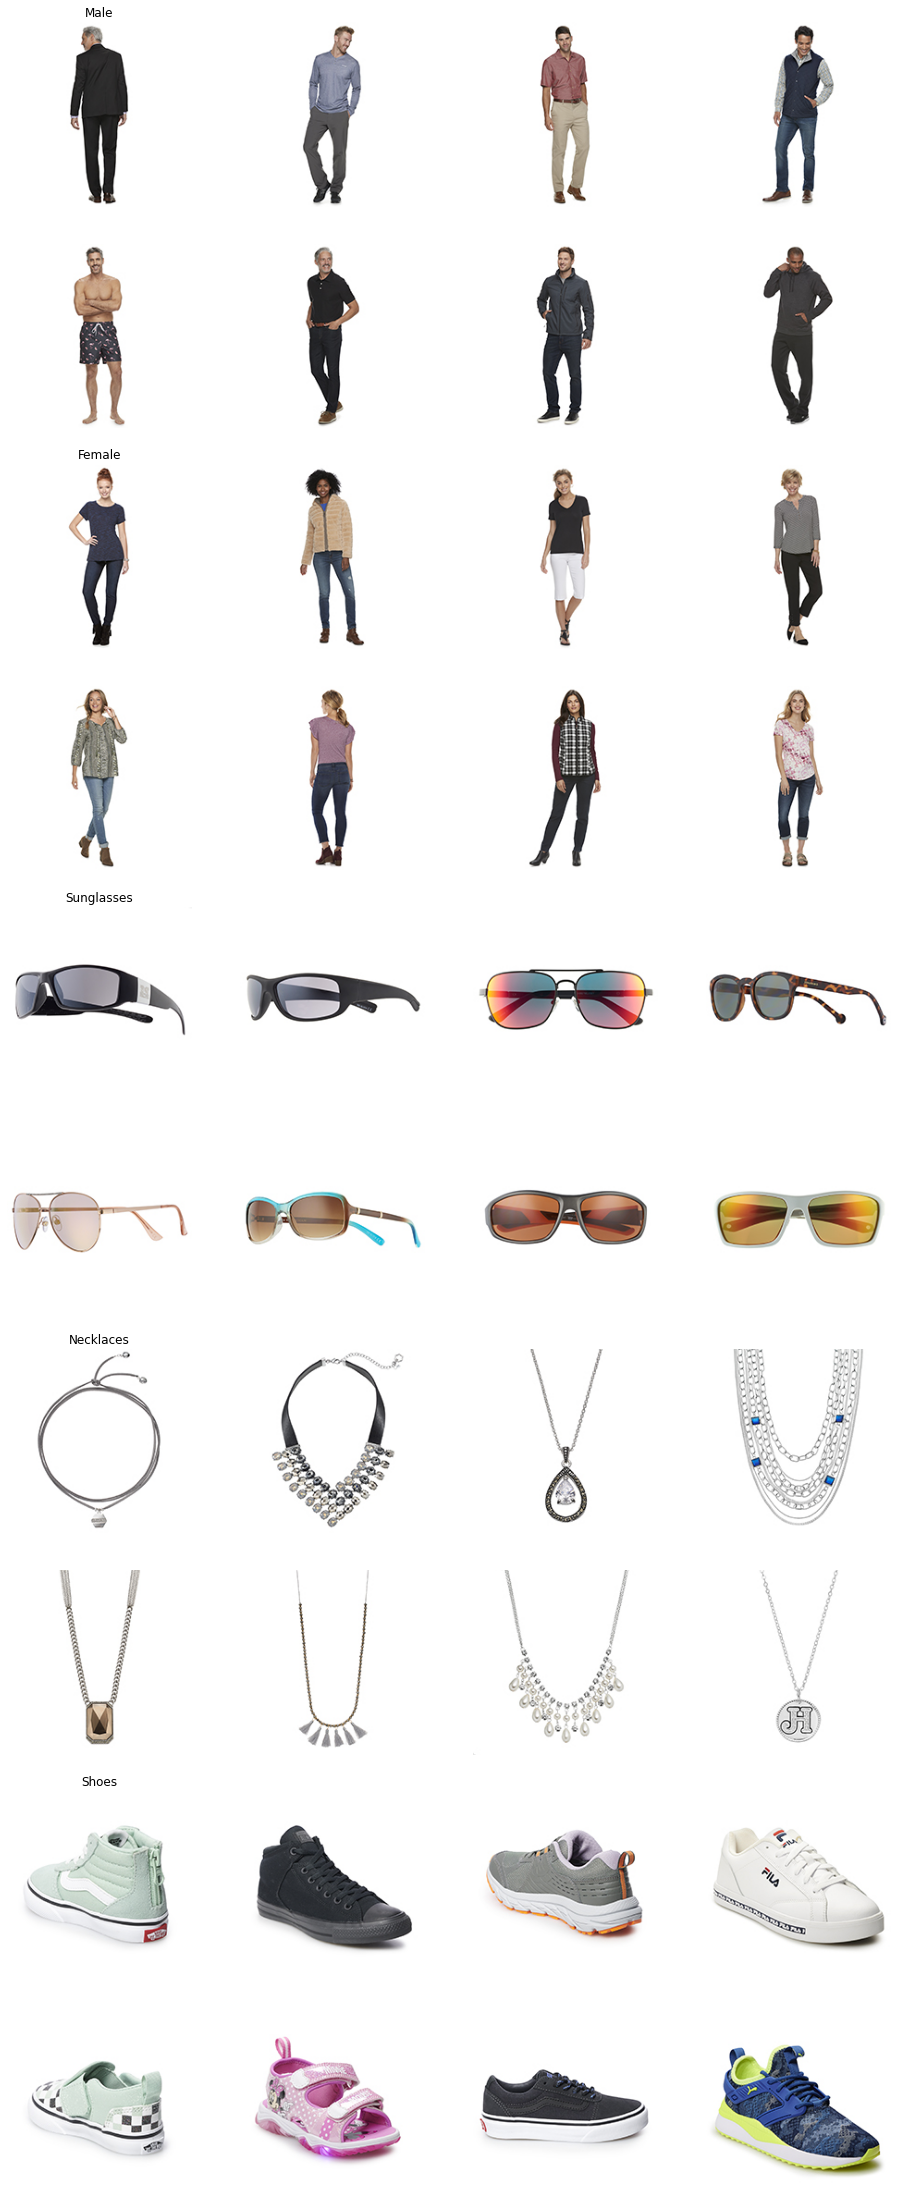

In [ ]:
nrows = 2 * (len(classnames))
ncols = 4 

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
random_pics = []
r_pic_titles = []

for d in train_dirs:
  for x in range (8):
    randomfile = random.choice(os.listdir(d))
    random_pics.append(os.path.join(d, randomfile))
    r_pic_titles.append(d[15:])

t = 8
for i, img_path in enumerate(random_pics):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  
  sp.axis('Off') # Don't show axes (or gridlines)

  if t % 8 == 0:
    sp.set_title(r_pic_titles[i])
  t+=1
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# Model Setup

## Import the Inception model

We are going to use all the layers in the model except for the last fully connected layer as it is specific to the [ImageNet](https://http://image-net.org/challenges/LSVRC/) competition.

In [ ]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptionV3_model = InceptionV3(input_shape = (200, 200, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

## Adding custom layers

In [ ]:
#Make all the pre-trained layers non-trainable
for layer in inceptionV3_model.layers:
  layer.trainable = False

# Flatten the output layer to 1 dimension
x = layers.Flatten()(inceptionV3_model.output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  

# Add a Sigmoid activation layer for binary, otherwise softmax.
if len(classnames)==2:
  x = layers.Dense  (1, activation='sigmoid')(x)

else:
  x = layers.Dense  (len(classnames), activation='softmax')(x)


model = Model(inceptionV3_model.input, x)

## Compile with different optimizers for testing 

**RMSprop** with a learning rate of **0.00005**

(In preliminary tests a learning rate of 0.0001 was also used. Overall the smaller rate provided better results.)

In [ ]:
# Compile for the appropriate classification loss
if len(classnames)==2:
  model.compile(optimizer = RMSprop(lr=0.00005), loss = 'binary_crossentropy', metrics = ['acc'])           
else:
  model.compile(optimizer = RMSprop(lr=0.00005), loss = 'categorical_crossentropy', metrics = ['acc'])


**Adam** with a learning rate of **0.0001**


In [ ]:
# Compile for the appropriate classification loss
if len(classnames)==2:
  model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])           
else:
  model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['acc'])


**Adagrad** with a learning rate of **0.0001**


In [ ]:
# Compile for the appropriate classification loss
if len(classnames)==2:
  model.compile(optimizer = Adagrad(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])           
else:
  model.compile(optimizer = Adagrad(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['acc'])


## Set up Generator to batch images

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1/255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1/255 )

# Flow training images in batches of 20 using train_datagen generator
if len(classnames)==2:
  train_generator = train_datagen.flow_from_directory(train_dir, 
                                                      batch_size = 20, 
                                                      class_mode = 'binary', 
                                                      target_size = (200, 200))
else:
  train_generator = train_datagen.flow_from_directory(train_dir, 
                                                      batch_size = 20,
                                                      class_mode = 'categorical', 
                                                      target_size = (200, 200))       

# Flow validation images in batches of 20 using test_datagen generator
if len(classnames)==2:
  validation_generator =  test_datagen.flow_from_directory( test_dir,
                                                            batch_size  = 20,
                                                            class_mode  = 'binary', 
                                                            target_size = (200, 200))
else:
  validation_generator =  test_datagen.flow_from_directory( test_dir,
                                                            batch_size  = 20,
                                                            class_mode = 'categorical', 
                                                            target_size = (200, 200))

Found 2400 images belonging to 3 classes.
Found 599 images belonging to 3 classes.


## Define a Callback to stop training once accuracy reaches 95% or above

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>=0.95):
      print("\nReached 95% accuracy so it's good to go!")
      self.model.stop_training = True

## Train the model

In [ ]:
callbacks = myCallback()
results = model.fit(train_generator, 
                    validation_data = validation_generator, 
                    steps_per_epoch = len(train_generator), 
                    epochs = 50, 
                    validation_steps = 20, 
                    verbose = 2, 
                    callbacks=[callbacks])

Epoch 1/50
120/120 - 24s - loss: 0.1504 - acc: 0.9454 - val_loss: 0.0125 - val_acc: 0.9950
Epoch 2/50

Reached 95% accuracy so it's good to go!
120/120 - 23s - loss: 0.0415 - acc: 0.9858 - val_loss: 0.0105 - val_acc: 0.9950


# Model comparsions

## Functions

In [ ]:
def acc_plotter(model_history):
  acc = model_history.history['acc']
  val_acc = model_history.history['val_acc']
  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [ ]:
def test_scores(model,name): 
  print('*************************************************************')
  print('Training score for {}:'.format(name), (model.evaluate(train_generator, verbose=0))[0])
  print('Training accuracy for {}:'.format(name), (model.evaluate(train_generator, verbose=0))[1])
  print('-------------------------------------------------------------')
  print('Test score for {}:'.format(name), (model.evaluate(validation_generator, verbose=0))[0])
  print('Test accuracy for {}:'.format(name), (model.evaluate(validation_generator, verbose=0))[1])
  print('*************************************************************')

## Evaluation

### RMSprop Optimizer model Tests

Two Classes

In [ ]:
description = 'Two Classes (Male-Female), 200 training images, RMSprop Optimizer'
c2_200_RMSprop = results
c2_200_RMSprop_m = model

In [ ]:
description = 'Two Classes (Male-Female), 400 training images, RMSprop Optimizer'
c2_400_RMSprop = results
c2_400_RMSprop_m = model

In [ ]:
description = 'Two Classes (Male-Female), 600 training images, RMSprop Optimizer'
c2_600_RMSprop = results
c2_600_RMSprop_m = model

In [ ]:
description = 'Two Classes (Male-Female), 800 training images, RMSprop Optimizer'
c2_800_RMSprop = results
c2_800_RMSprop_m = model

Three Classes

In [ ]:
description = 'Three Classes (Necklace-Shoes-Sunglasses), 200 training images, RMSprop Optimizer'
c3_200_RMSprop = results
c3_200_RMSprop_m = model

In [ ]:
description = 'Three Classes (Necklace-Shoes-Sunglasses), 400 training images, RMSprop Optimizer'
c3_400_RMSprop = results
c3_400_RMSprop_m = model

In [ ]:
description = 'Three Classes (Necklace-Shoes-Sunglasses), 600 training images, RMSprop Optimizer'
c3_600_RMSprop = results
c3_600_RMSprop_m = model

In [ ]:
description = 'Three Classes (Necklace-Shoes-Sunglasses), 800 training images, RMSprop Optimizer'
c3_800_RMSprop = results
c3_800_RMSprop_m = model

Five Classes

In [ ]:
description = 'Five Classes, 200 training images, RMSprop Optimizer'
c5_200_RMSprop = results
c5_200_RMSprop_m = model

In [ ]:
description = 'Five Classes, 400 training images, RMSprop Optimizer'
c5_400_RMSprop = results
c5_400_RMSprop_m = model

In [ ]:
description = 'Five Classes, 600 training images, RMSprop Optimizer'
c5_600_RMSprop = results
c5_600_RMSprop_m = model

In [ ]:
description = 'Five Classes, 800 training images, RMSprop Optimizer'
c5_800_RMSprop = results
c5_800_RMSprop_m = model

### Adam Optimizer model Tests

Two Classes

In [ ]:
description = 'Two Classes (Male-Female), 200 training images, Adam Optimizer'
c2_200_Adam = results
c2_200_Adam_m = model

In [ ]:
description = 'Two Classes (Male-Female), 400 training images, Adam Optimizer'
c2_400_Adam = results
c2_400_Adam_m = model

In [ ]:
description = 'Two Classes (Male-Female), 600 training images, Adam Optimizer'
c2_600_Adam = results
c2_600_Adam_m = model

In [ ]:
description = 'Two Classes (Male-Female), 800 training images, Adam Optimizer'
c2_800_Adam = results
c2_800_Adam_m = model

Three Classes

In [ ]:
description = 'Three Classes (Necklace-Shoes-Sunglasses), 200 training images, Adam Optimizer'
c3_200_Adam = results
c3_200_Adam_m = model

In [ ]:
description = 'Three Classes (Necklace-Shoes-Sunglasses), 400 training images, Adam Optimizer'
c3_400_Adam = results
c3_400_Adam_m = model

In [ ]:
description = 'Three Classes (Necklace-Shoes-Sunglasses), 600 training images, Adam Optimizer'
c3_600_Adam = results
c3_600_Adam_m = model

In [ ]:
description = 'Three Classes (Necklace-Shoes-Sunglasses), 800 training images, Adam Optimizer'
c3_800_Adam = results
c3_800_Adam_m = model

Five Classes

In [ ]:
description = 'Five Classes, 200 training images, Adam Optimizer'
c5_200_Adam = results
c5_200_Adam_m = model

In [ ]:
description = 'Five Classes, 400 training images, Adam Optimizer'
c5_400_Adam = results
c5_400_Adam_m = model

In [ ]:
description = 'Five Classes, 600 training images, Adam Optimizer'
c5_600_Adam = results
c5_600_Adam_m = model

In [ ]:
description = 'Five Classes, 800 training images, Adam Optimizer'
c5_800_Adam = results
c5_800_Adam_m = model

### Adagrad Optimizer model Tests

Two Classes

In [ ]:
description = 'Two Classes (Male-Female), 200 training images, Adagrad Optimizer'
c2_200_Adagrad = results
c2_200_Adagrad_m = model

In [ ]:
description = 'Two Classes (Male-Female), 400 training images, Adagrad Optimizer'
c2_400_Adagrad = results
c2_400_Adagrad_m = model

In [ ]:
description = 'Two Classes (Male-Female), 600 training images, Adagrad Optimizer'
c2_600_Adagrad = results
c2_600_Adagrad_m = model

In [ ]:
description = 'Two Classes (Male-Female), 800 training images, Adagrad Optimizer'
c2_800_Adagrad = results
c2_800_Adagrad_m = model

Three Classes

In [ ]:
description = 'Three Classes (Necklace-Shoes-Sunglasses), 200 training images, Adagrad Optimizer'
c3_200_Adagrad = results
c3_200_Adagrad_m = model

In [ ]:
description = 'Three Classes (Necklace-Shoes-Sunglasses), 400 training images, Adagrad Optimizer'
c3_400_Adagrad = results
c3_400_Adagrad_m = model

In [ ]:
description = 'Three Classes (Necklace-Shoes-Sunglasses), 600 training images, Adagrad Optimizer'
c3_600_Adagrad = results
c3_600_Adagrad_m = model

In [ ]:
description = 'Three Classes (Necklace-Shoes-Sunglasses), 800 training images, Adagrad Optimizer'
c3_800_Adagrad = results
c3_800_Adagrad_m = model

Five Classes

In [ ]:
description = 'Five Classes, 200 training images, Adagrad Optimizer'
c5_200_Adagrad = results
c5_200_Adagrad_m = model

In [ ]:
description = 'Five Classes, 400 training images, Adagrad Optimizer'
c5_400_Adagrad = results
c5_400_Adagrad_m = model

In [ ]:
description = 'Five Classes, 600 training images, Adagrad Optimizer'
c5_600_Adagrad = results
c5_600_Adagrad_m = model

In [ ]:
description = 'Five Classes, 800 training images, Adagrad Optimizer'
c5_800_Adagrad = results
c5_800_Adagrad_m = model

### RMSprop Training Plots

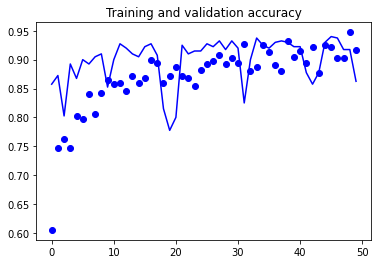

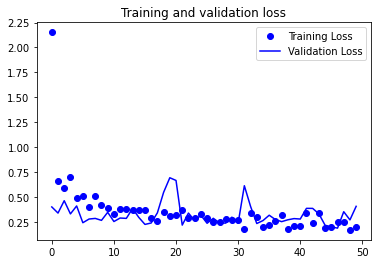

In [ ]:
acc_plotter(c2_200_RMSprop)

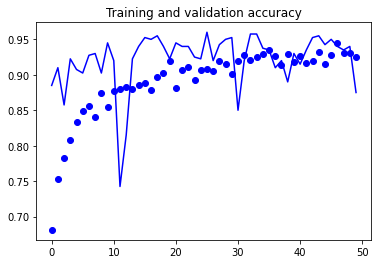

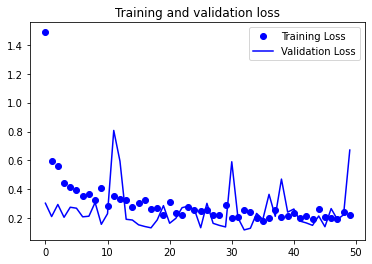

In [ ]:
acc_plotter(c2_400_RMSprop)

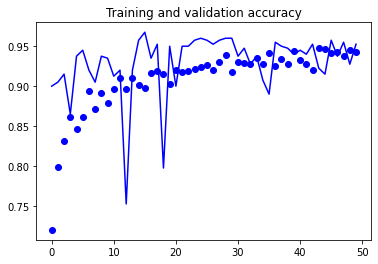

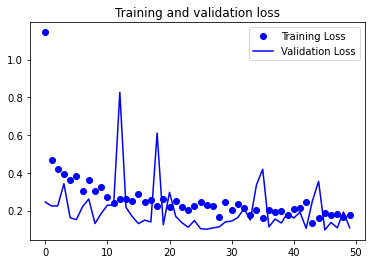

In [ ]:
acc_plotter(c2_600_RMSprop)

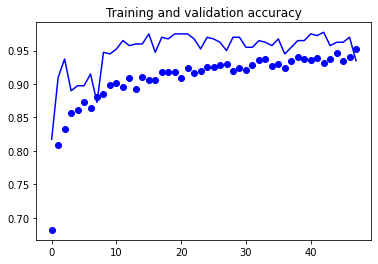

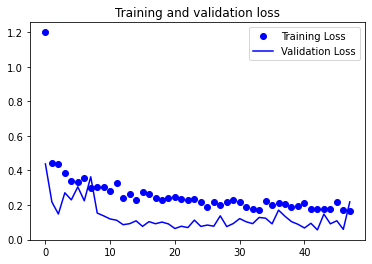

In [ ]:
acc_plotter(c2_800_RMSprop)

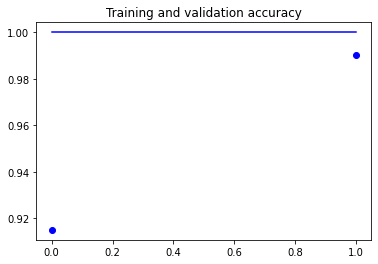

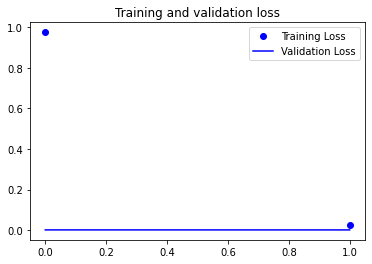

In [ ]:
acc_plotter(c3_200_RMSprop)

In [ ]:
acc_plotter(c3_400_RMSprop)

NameError: ignored

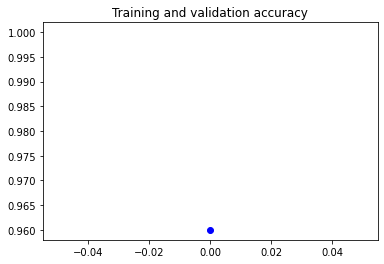

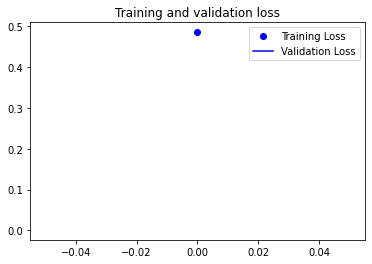

In [ ]:
acc_plotter(c3_600_RMSprop)

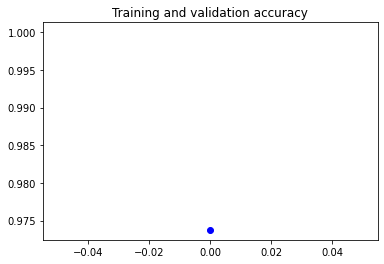

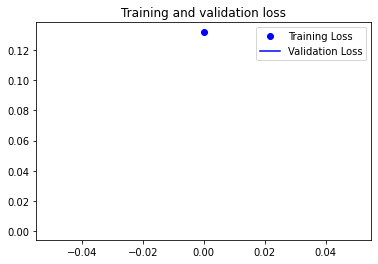

In [ ]:
acc_plotter(c3_800_RMSprop)

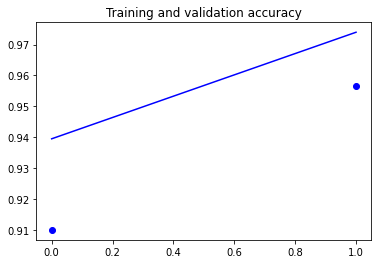

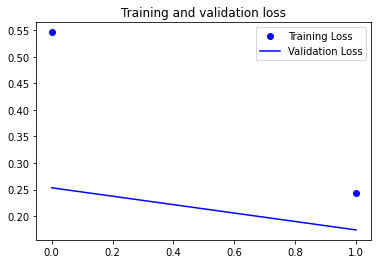

In [ ]:
acc_plotter(c5_200_RMSprop)

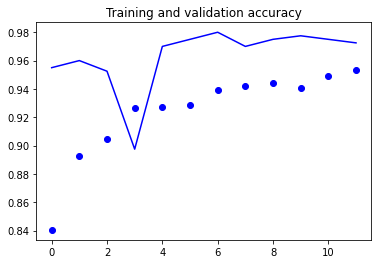

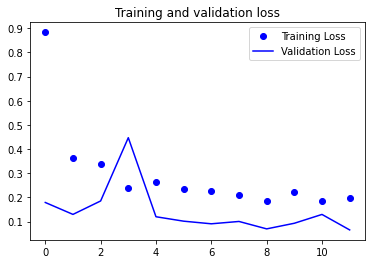

In [ ]:
acc_plotter(c5_400_RMSprop)

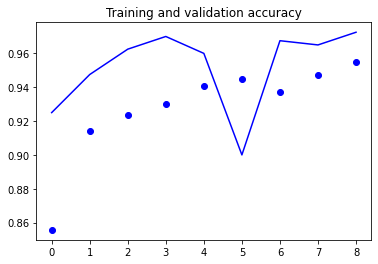

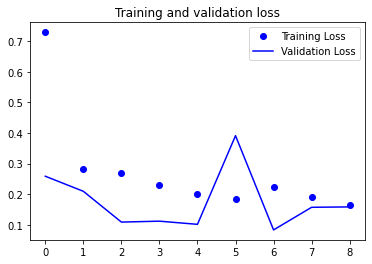

In [ ]:
acc_plotter(c5_600_RMSprop)

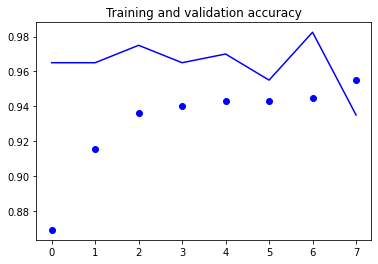

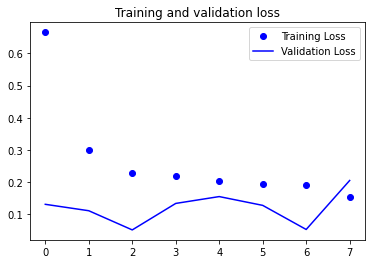

In [ ]:
acc_plotter(c5_800_RMSprop)

### Adam Training Plots

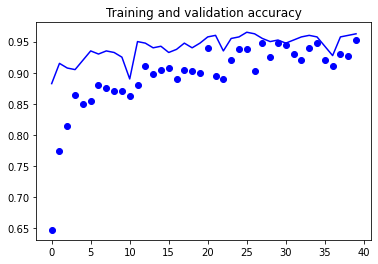

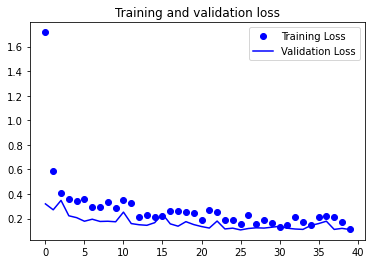

In [ ]:
acc_plotter(c2_200_Adam)

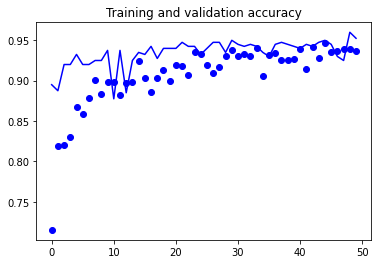

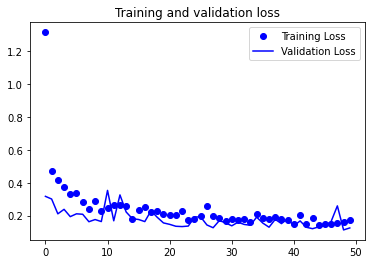

In [ ]:
acc_plotter(c2_400_Adam)

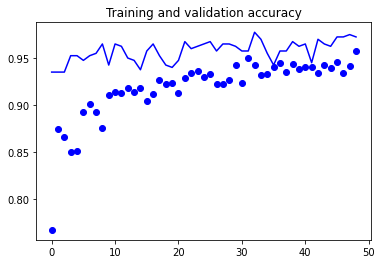

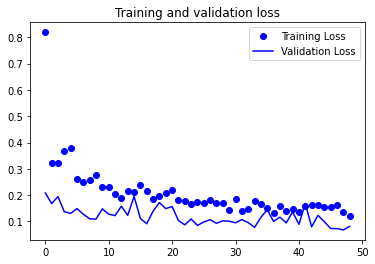

In [ ]:
acc_plotter(c2_600_Adam)

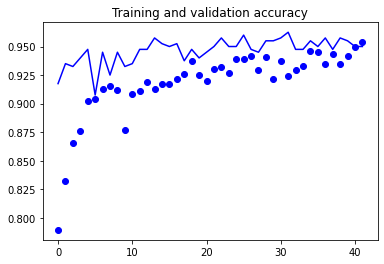

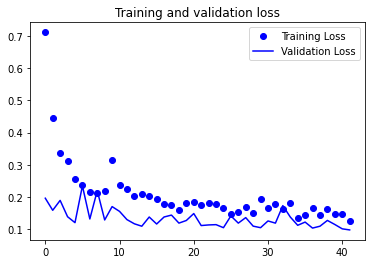

In [ ]:
acc_plotter(c2_800_Adam)

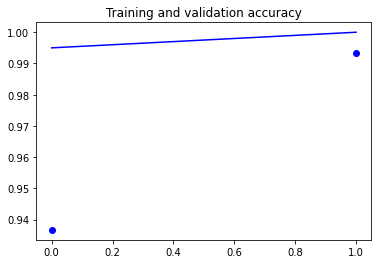

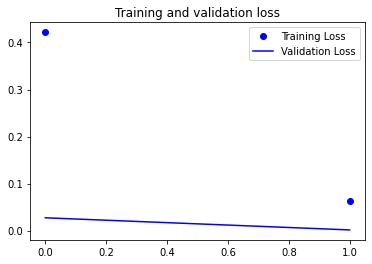

In [ ]:
acc_plotter(c3_200_Adam)

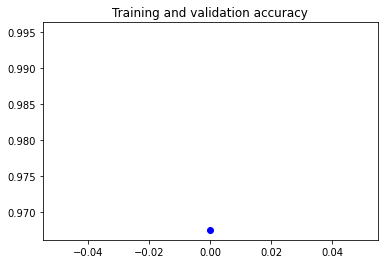

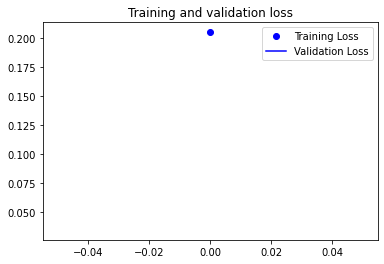

In [ ]:
acc_plotter(c3_400_Adam)

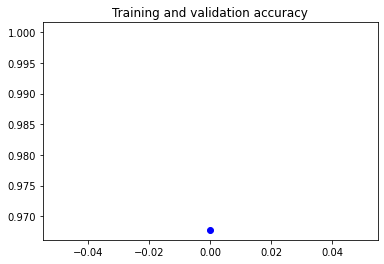

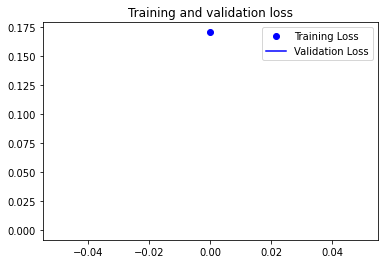

In [ ]:
acc_plotter(c3_600_Adam)

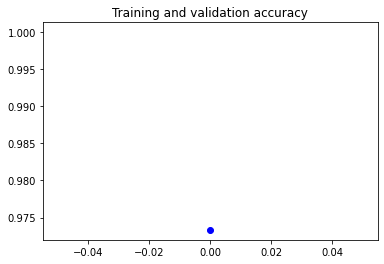

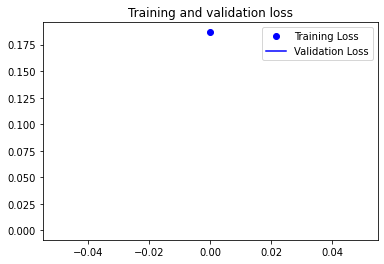

In [ ]:
acc_plotter(c3_800_Adam)

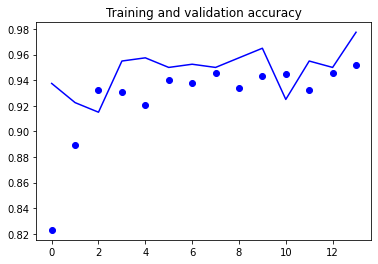

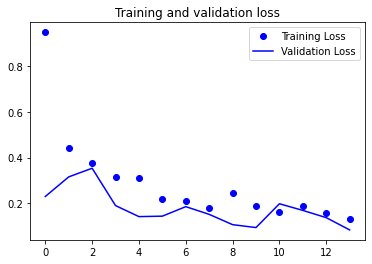

In [ ]:
acc_plotter(c5_200_Adam)

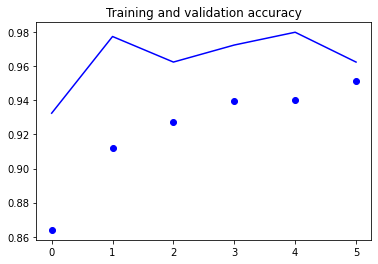

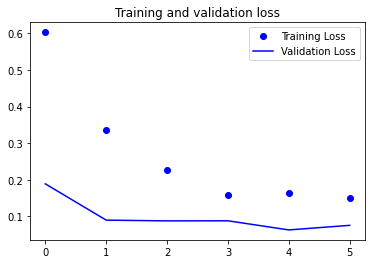

In [ ]:
acc_plotter(c5_400_Adam)

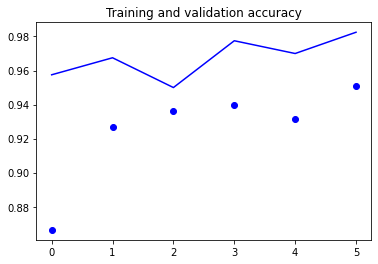

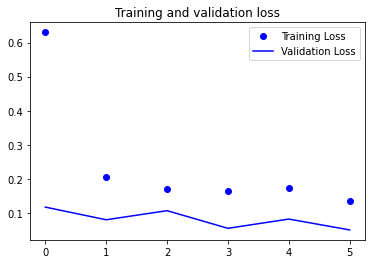

In [ ]:
acc_plotter(c5_600_Adam)

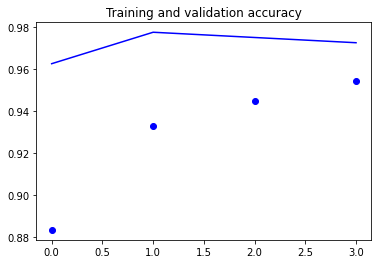

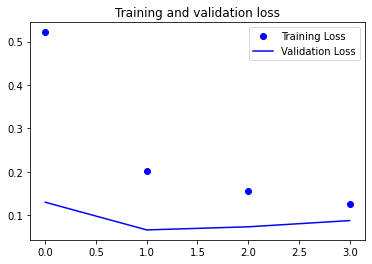

In [ ]:
acc_plotter(c5_800_Adam)

### Adagrad Training Plots

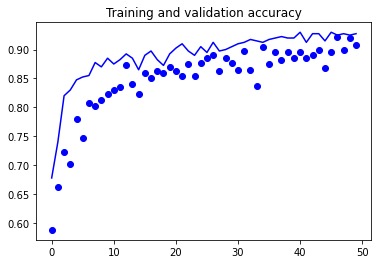

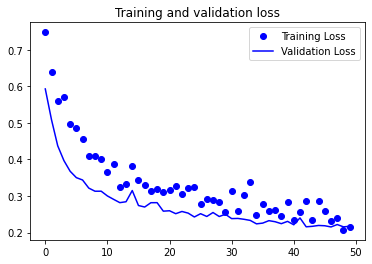

In [ ]:
acc_plotter(c2_200_Adagrad)

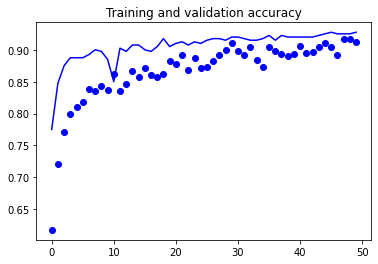

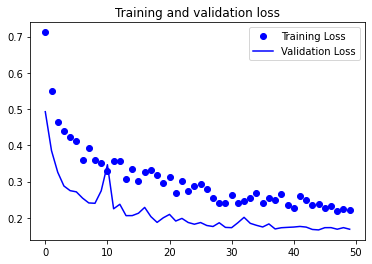

In [ ]:
acc_plotter(c2_400_Adagrad)

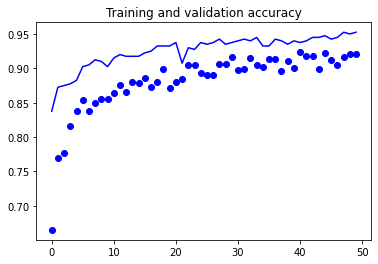

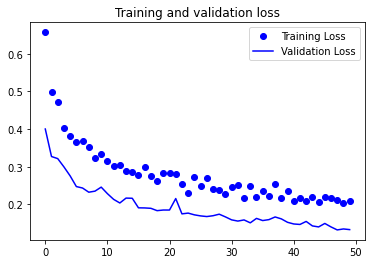

In [ ]:
acc_plotter(c2_600_Adagrad)

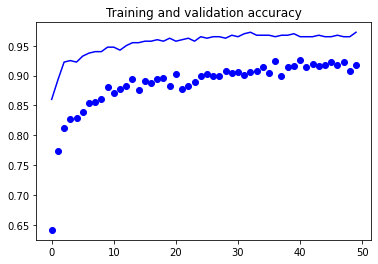

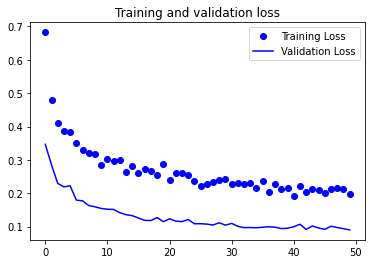

In [ ]:
acc_plotter(c2_800_Adagrad)

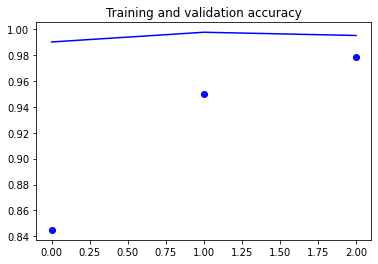

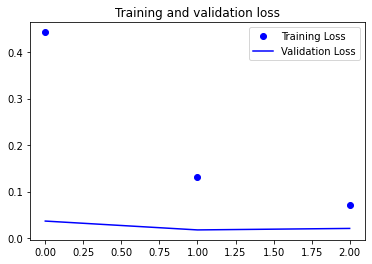

In [ ]:
acc_plotter(c3_200_Adagrad)

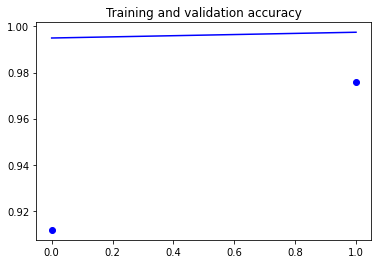

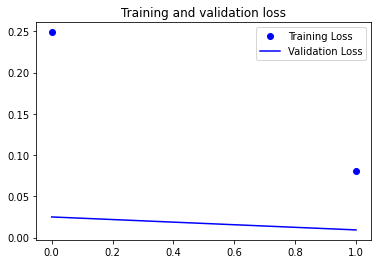

In [ ]:
acc_plotter(c3_400_Adagrad)

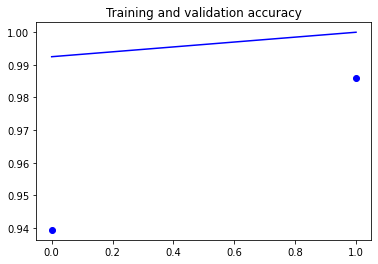

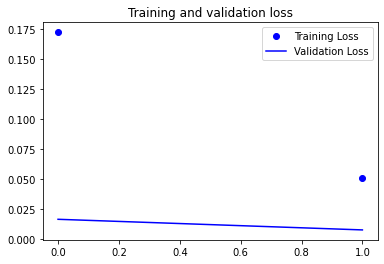

In [ ]:
acc_plotter(c3_600_Adagrad)

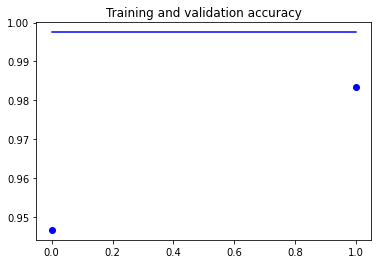

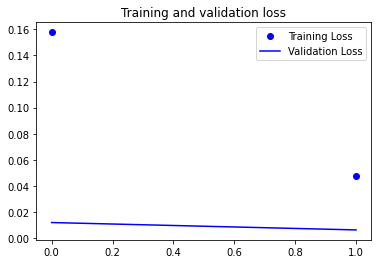

In [ ]:
acc_plotter(c3_800_Adagrad)

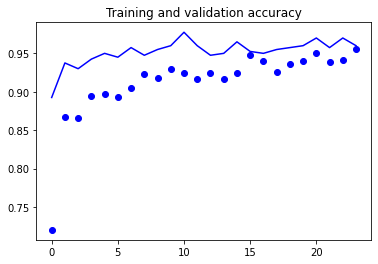

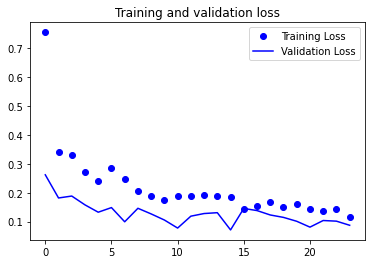

In [ ]:
acc_plotter(c5_200_Adagrad)

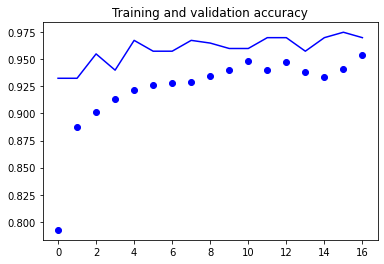

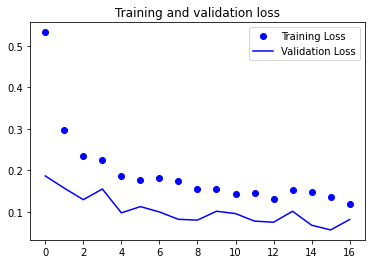

In [ ]:
acc_plotter(c5_400_Adagrad)

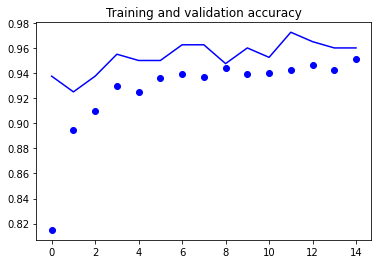

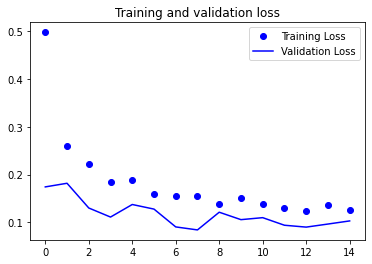

In [ ]:
acc_plotter(c5_600_Adagrad)

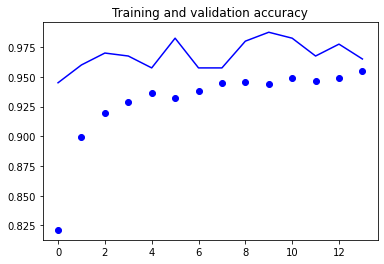

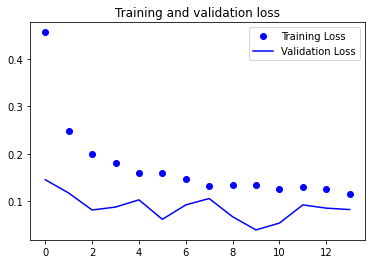

In [ ]:
acc_plotter(c5_800_Adagrad)

### RMSprop Scores

In [ ]:
test_scores(c2_200_RMSprop_m, description) 

*************************************************************
Training score for Two Classes (Male-Female), 200 training images, RMSprop Optimizer: 0.3408122956752777
Training accuracy for Two Classes (Male-Female), 200 training images, RMSprop Optimizer: 0.8849999904632568
-------------------------------------------------------------
Test score for Two Classes (Male-Female), 200 training images, RMSprop Optimizer: 0.40816161036491394
Test accuracy for Two Classes (Male-Female), 200 training images, RMSprop Optimizer: 0.862500011920929
*************************************************************


In [ ]:
test_scores(c2_400_RMSprop_m, description) 

*************************************************************
Training score for Two Classes (Male-Female), 400 training images, RMSprop Optimizer: 0.4920547604560852
Training accuracy for Two Classes (Male-Female), 400 training images, RMSprop Optimizer: 0.875
-------------------------------------------------------------
Test score for Two Classes (Male-Female), 400 training images, RMSprop Optimizer: 0.6714584827423096
Test accuracy for Two Classes (Male-Female), 400 training images, RMSprop Optimizer: 0.875
*************************************************************


In [ ]:
test_scores(c2_600_RMSprop_m, description) 

*************************************************************
Training score for Two Classes (Male-Female), 600 training images, RMSprop Optimizer: 0.11746185272932053
Training accuracy for Two Classes (Male-Female), 600 training images, RMSprop Optimizer: 0.9633333086967468
-------------------------------------------------------------
Test score for Two Classes (Male-Female), 600 training images, RMSprop Optimizer: 0.10899610817432404
Test accuracy for Two Classes (Male-Female), 600 training images, RMSprop Optimizer: 0.9524999856948853
*************************************************************


In [ ]:
test_scores(c2_800_RMSprop_m, description) 

*************************************************************
Training score for Two Classes (Male-Female), 800 training images, RMSprop Optimizer: 0.3029179275035858
Training accuracy for Two Classes (Male-Female), 800 training images, RMSprop Optimizer: 0.8812500238418579
-------------------------------------------------------------
Test score for Two Classes (Male-Female), 800 training images, RMSprop Optimizer: 0.21809570491313934
Test accuracy for Two Classes (Male-Female), 800 training images, RMSprop Optimizer: 0.9350000023841858
*************************************************************


In [ ]:
test_scores(c3_200_RMSprop_m, description) 


*************************************************************
Training score for Three Classes (Necklace-Shoes-Sunglasses), 200 training images, RMSprop Optimizer: 0.0039679124020040035
Training accuracy for Three Classes (Necklace-Shoes-Sunglasses), 200 training images, RMSprop Optimizer: 0.9950000047683716
-------------------------------------------------------------
Test score for Three Classes (Necklace-Shoes-Sunglasses), 200 training images, RMSprop Optimizer: 0.0007494115852750838
Test accuracy for Three Classes (Necklace-Shoes-Sunglasses), 200 training images, RMSprop Optimizer: 1.0
*************************************************************


In [ ]:
test_scores(c3_400_RMSprop_m, description) 

*************************************************************
Training score for Three Classes (Necklace-Shoes-Sunglasses), 400 training images, RMSprop Optimizer: 0.03867800161242485
Training accuracy for Three Classes (Necklace-Shoes-Sunglasses), 400 training images, RMSprop Optimizer: 0.9850000143051147
-------------------------------------------------------------
Test score for Three Classes (Necklace-Shoes-Sunglasses), 400 training images, RMSprop Optimizer: 0.0069342185743153095
Test accuracy for Three Classes (Necklace-Shoes-Sunglasses), 400 training images, RMSprop Optimizer: 0.9983333349227905
*************************************************************


In [ ]:
test_scores(c3_600_RMSprop_m, description) 

*************************************************************
Training score for Three Classes (Necklace-Shoes-Sunglasses), 600 training images, RMSprop Optimizer: 0.1237310841679573
Training accuracy for Three Classes (Necklace-Shoes-Sunglasses), 600 training images, RMSprop Optimizer: 0.9788771271705627
-------------------------------------------------------------
Test score for Three Classes (Necklace-Shoes-Sunglasses), 600 training images, RMSprop Optimizer: 0.0008537967805750668
Test accuracy for Three Classes (Necklace-Shoes-Sunglasses), 600 training images, RMSprop Optimizer: 1.0
*************************************************************


In [ ]:
test_scores(c3_800_RMSprop_m, description) 

*************************************************************
Training score for Three Classes (Necklace-Shoes-Sunglasses), 800 training images, RMSprop Optimizer: 0.025455648079514503
Training accuracy for Three Classes (Necklace-Shoes-Sunglasses), 800 training images, RMSprop Optimizer: 0.9954166412353516
-------------------------------------------------------------
Test score for Three Classes (Necklace-Shoes-Sunglasses), 800 training images, RMSprop Optimizer: 0.013544127345085144
Test accuracy for Three Classes (Necklace-Shoes-Sunglasses), 800 training images, RMSprop Optimizer: 0.9983305335044861
*************************************************************


In [ ]:
test_scores(c5_200_RMSprop_m, description) 


*************************************************************
Training score for Five Classes, 200 training images, RMSprop Optimizer: 0.19613011181354523
Training accuracy for Five Classes, 200 training images, RMSprop Optimizer: 0.9675998091697693
-------------------------------------------------------------
Test score for Five Classes, 200 training images, RMSprop Optimizer: 0.15089434385299683
Test accuracy for Five Classes, 200 training images, RMSprop Optimizer: 0.9789999127388
*************************************************************


In [ ]:
test_scores(c5_400_RMSprop_m, description) 

*************************************************************
Training score for Five Classes, 400 training images, RMSprop Optimizer: 0.2546807825565338
Training accuracy for Five Classes, 400 training images, RMSprop Optimizer: 0.934499979019165
-------------------------------------------------------------
Test score for Five Classes, 400 training images, RMSprop Optimizer: 0.12836064398288727
Test accuracy for Five Classes, 400 training images, RMSprop Optimizer: 0.9570000171661377
*************************************************************


In [ ]:
test_scores(c5_600_RMSprop_m, description) 

*************************************************************
Training score for Five Classes, 600 training images, RMSprop Optimizer: 0.11355695873498917
Training accuracy for Five Classes, 600 training images, RMSprop Optimizer: 0.965666651725769
-------------------------------------------------------------
Test score for Five Classes, 600 training images, RMSprop Optimizer: 0.12427016347646713
Test accuracy for Five Classes, 600 training images, RMSprop Optimizer: 0.9739739894866943
*************************************************************


In [ ]:
test_scores(c5_800_RMSprop_m, description) 

*************************************************************
Training score for Five Classes, 800 training images, RMSprop Optimizer: 0.16477183997631073
Training accuracy for Five Classes, 800 training images, RMSprop Optimizer: 0.9569892287254333
-------------------------------------------------------------
Test score for Five Classes, 800 training images, RMSprop Optimizer: 0.16767153143882751
Test accuracy for Five Classes, 800 training images, RMSprop Optimizer: 0.9470000267028809
*************************************************************


### Adam Scores

In [ ]:
test_scores(c2_200_Adam_m, description) 

*************************************************************
Training score for Two Classes (Male-Female), 200 training images, Adam Optimizer: 0.16077156364917755
Training accuracy for Two Classes (Male-Female), 200 training images, Adam Optimizer: 0.9524999856948853
-------------------------------------------------------------
Test score for Two Classes (Male-Female), 200 training images, Adam Optimizer: 0.11108145862817764
Test accuracy for Two Classes (Male-Female), 200 training images, Adam Optimizer: 0.9624999761581421
*************************************************************


In [ ]:
test_scores(c2_400_Adam_m, description) 

*************************************************************
Training score for Two Classes (Male-Female), 400 training images, Adam Optimizer: 0.1176629513502121
Training accuracy for Two Classes (Male-Female), 400 training images, Adam Optimizer: 0.9549999833106995
-------------------------------------------------------------
Test score for Two Classes (Male-Female), 400 training images, Adam Optimizer: 0.12478511780500412
Test accuracy for Two Classes (Male-Female), 400 training images, Adam Optimizer: 0.9524999856948853
*************************************************************


In [ ]:
test_scores(c2_600_Adam_m, description) 

*************************************************************
Training score for Two Classes (Male-Female), 600 training images, Adam Optimizer: 0.12195704132318497
Training accuracy for Two Classes (Male-Female), 600 training images, Adam Optimizer: 0.9508333206176758
-------------------------------------------------------------
Test score for Two Classes (Male-Female), 600 training images, Adam Optimizer: 0.08132215589284897
Test accuracy for Two Classes (Male-Female), 600 training images, Adam Optimizer: 0.9725000262260437
*************************************************************


In [ ]:
test_scores(c2_800_Adam_m, description) 

*************************************************************
Training score for Two Classes (Male-Female), 800 training images, Adam Optimizer: 0.10290402173995972
Training accuracy for Two Classes (Male-Female), 800 training images, Adam Optimizer: 0.9556249976158142
-------------------------------------------------------------
Test score for Two Classes (Male-Female), 800 training images, Adam Optimizer: 0.0979682132601738
Test accuracy for Two Classes (Male-Female), 800 training images, Adam Optimizer: 0.949999988079071
*************************************************************


In [ ]:
test_scores(c3_200_Adam_m, description) 


*************************************************************
Training score for Three Classes (Necklace-Shoes-Sunglasses), 200 training images, Adam Optimizer: 0.00028857841971330345
Training accuracy for Three Classes (Necklace-Shoes-Sunglasses), 200 training images, Adam Optimizer: 0.996666669845581
-------------------------------------------------------------
Test score for Three Classes (Necklace-Shoes-Sunglasses), 200 training images, Adam Optimizer: 0.0020309865940362215
Test accuracy for Three Classes (Necklace-Shoes-Sunglasses), 200 training images, Adam Optimizer: 1.0
*************************************************************


In [ ]:
test_scores(c3_400_Adam_m, description) 

*************************************************************
Training score for Three Classes (Necklace-Shoes-Sunglasses), 400 training images, Adam Optimizer: 0.2059289962053299
Training accuracy for Three Classes (Necklace-Shoes-Sunglasses), 400 training images, Adam Optimizer: 0.9725000262260437
-------------------------------------------------------------
Test score for Three Classes (Necklace-Shoes-Sunglasses), 400 training images, Adam Optimizer: 0.044275786727666855
Test accuracy for Three Classes (Necklace-Shoes-Sunglasses), 400 training images, Adam Optimizer: 0.9916666746139526
*************************************************************


In [ ]:
test_scores(c3_600_Adam_m, description) 

*************************************************************
Training score for Three Classes (Necklace-Shoes-Sunglasses), 600 training images, Adam Optimizer: 0.015258879400789738
Training accuracy for Three Classes (Necklace-Shoes-Sunglasses), 600 training images, Adam Optimizer: 0.9972206950187683
-------------------------------------------------------------
Test score for Three Classes (Necklace-Shoes-Sunglasses), 600 training images, Adam Optimizer: 0.0014210104709491134
Test accuracy for Three Classes (Necklace-Shoes-Sunglasses), 600 training images, Adam Optimizer: 0.9983333349227905
*************************************************************


In [ ]:
test_scores(c3_800_Adam_m, description) 

*************************************************************
Training score for Three Classes (Necklace-Shoes-Sunglasses), 800 training images, Adam Optimizer: 0.052092235535383224
Training accuracy for Three Classes (Necklace-Shoes-Sunglasses), 800 training images, Adam Optimizer: 0.9908333420753479
-------------------------------------------------------------
Test score for Three Classes (Necklace-Shoes-Sunglasses), 800 training images, Adam Optimizer: 0.0003359783731866628
Test accuracy for Three Classes (Necklace-Shoes-Sunglasses), 800 training images, Adam Optimizer: 1.0
*************************************************************


In [ ]:
test_scores(c5_200_Adam_m, description) 


*************************************************************
Training score for Five Classes, 200 training images, Adam Optimizer: 0.0762547105550766
Training accuracy for Five Classes, 200 training images, Adam Optimizer: 0.9660000205039978
-------------------------------------------------------------
Test score for Five Classes, 200 training images, Adam Optimizer: 0.08679211884737015
Test accuracy for Five Classes, 200 training images, Adam Optimizer: 0.9710000157356262
*************************************************************


In [ ]:
test_scores(c5_400_Adam_m, description) 

*************************************************************
Training score for Five Classes, 400 training images, Adam Optimizer: 0.09150560200214386
Training accuracy for Five Classes, 400 training images, Adam Optimizer: 0.9614999890327454
-------------------------------------------------------------
Test score for Five Classes, 400 training images, Adam Optimizer: 0.08017569035291672
Test accuracy for Five Classes, 400 training images, Adam Optimizer: 0.9729729890823364
*************************************************************


In [ ]:
test_scores(c5_600_Adam_m, description) 

*************************************************************
Training score for Five Classes, 600 training images, Adam Optimizer: 0.10556810349225998
Training accuracy for Five Classes, 600 training images, Adam Optimizer: 0.9520000219345093
-------------------------------------------------------------
Test score for Five Classes, 600 training images, Adam Optimizer: 0.07596917450428009
Test accuracy for Five Classes, 600 training images, Adam Optimizer: 0.9709709882736206
*************************************************************


In [ ]:
test_scores(c5_800_Adam_m, description) 

*************************************************************
Training score for Five Classes, 800 training images, Adam Optimizer: 0.11042942106723785
Training accuracy for Five Classes, 800 training images, Adam Optimizer: 0.9559890031814575
-------------------------------------------------------------
Test score for Five Classes, 800 training images, Adam Optimizer: 0.07330593466758728
Test accuracy for Five Classes, 800 training images, Adam Optimizer: 0.9750000238418579
*************************************************************


### Adagrad Scores

In [ ]:
test_scores(c2_200_Adagrad_m, description) 

*************************************************************
Training score for Two Classes (Male-Female), 200 training images, Adagrad Optimizer: 0.22403591871261597
Training accuracy for Two Classes (Male-Female), 200 training images, Adagrad Optimizer: 0.9325000047683716
-------------------------------------------------------------
Test score for Two Classes (Male-Female), 200 training images, Adagrad Optimizer: 0.21700553596019745
Test accuracy for Two Classes (Male-Female), 200 training images, Adagrad Optimizer: 0.9275000095367432
*************************************************************


In [ ]:
test_scores(c2_400_Adagrad_m, description) 

*************************************************************
Training score for Two Classes (Male-Female), 400 training images, Adagrad Optimizer: 0.18957173824310303
Training accuracy for Two Classes (Male-Female), 400 training images, Adagrad Optimizer: 0.9112499952316284
-------------------------------------------------------------
Test score for Two Classes (Male-Female), 400 training images, Adagrad Optimizer: 0.16865462064743042
Test accuracy for Two Classes (Male-Female), 400 training images, Adagrad Optimizer: 0.9275000095367432
*************************************************************


In [ ]:
test_scores(c2_600_Adagrad_m, description) 

*************************************************************
Training score for Two Classes (Male-Female), 600 training images, Adagrad Optimizer: 0.20729555189609528
Training accuracy for Two Classes (Male-Female), 600 training images, Adagrad Optimizer: 0.9200000166893005
-------------------------------------------------------------
Test score for Two Classes (Male-Female), 600 training images, Adagrad Optimizer: 0.1333267092704773
Test accuracy for Two Classes (Male-Female), 600 training images, Adagrad Optimizer: 0.9524999856948853
*************************************************************


In [ ]:
test_scores(c2_800_Adagrad_m, description) 

*************************************************************
Training score for Two Classes (Male-Female), 800 training images, Adagrad Optimizer: 0.1868528127670288
Training accuracy for Two Classes (Male-Female), 800 training images, Adagrad Optimizer: 0.9312499761581421
-------------------------------------------------------------
Test score for Two Classes (Male-Female), 800 training images, Adagrad Optimizer: 0.09011190384626389
Test accuracy for Two Classes (Male-Female), 800 training images, Adagrad Optimizer: 0.9725000262260437
*************************************************************


In [ ]:
test_scores(c3_200_Adagrad_m, description) 


*************************************************************
Training score for Three Classes (Necklace-Shoes-Sunglasses), 200 training images, Adagrad Optimizer: 0.05712089687585831
Training accuracy for Three Classes (Necklace-Shoes-Sunglasses), 200 training images, Adagrad Optimizer: 0.9916666746139526
-------------------------------------------------------------
Test score for Three Classes (Necklace-Shoes-Sunglasses), 200 training images, Adagrad Optimizer: 0.015571166761219501
Test accuracy for Three Classes (Necklace-Shoes-Sunglasses), 200 training images, Adagrad Optimizer: 0.996666669845581
*************************************************************


In [ ]:
test_scores(c3_400_Adagrad_m, description) 

*************************************************************
Training score for Three Classes (Necklace-Shoes-Sunglasses), 400 training images, Adagrad Optimizer: 0.04390643909573555
Training accuracy for Three Classes (Necklace-Shoes-Sunglasses), 400 training images, Adagrad Optimizer: 0.985821545124054
-------------------------------------------------------------
Test score for Three Classes (Necklace-Shoes-Sunglasses), 400 training images, Adagrad Optimizer: 0.008066993206739426
Test accuracy for Three Classes (Necklace-Shoes-Sunglasses), 400 training images, Adagrad Optimizer: 1.0
*************************************************************


In [ ]:
test_scores(c3_600_Adagrad_m, description) 

*************************************************************
Training score for Three Classes (Necklace-Shoes-Sunglasses), 600 training images, Adagrad Optimizer: 0.04122219234704971
Training accuracy for Three Classes (Necklace-Shoes-Sunglasses), 600 training images, Adagrad Optimizer: 0.9905502796173096
-------------------------------------------------------------
Test score for Three Classes (Necklace-Shoes-Sunglasses), 600 training images, Adagrad Optimizer: 0.009404823184013367
Test accuracy for Three Classes (Necklace-Shoes-Sunglasses), 600 training images, Adagrad Optimizer: 0.9983333349227905
*************************************************************


In [ ]:
test_scores(c3_800_Adagrad_m, description) 

*************************************************************
Training score for Three Classes (Necklace-Shoes-Sunglasses), 800 training images, Adagrad Optimizer: 0.027110526338219643
Training accuracy for Three Classes (Necklace-Shoes-Sunglasses), 800 training images, Adagrad Optimizer: 0.9920833110809326
-------------------------------------------------------------
Test score for Three Classes (Necklace-Shoes-Sunglasses), 800 training images, Adagrad Optimizer: 0.008186749182641506
Test accuracy for Three Classes (Necklace-Shoes-Sunglasses), 800 training images, Adagrad Optimizer: 0.9966611266136169
*************************************************************


In [ ]:
test_scores(c5_200_Adagrad_m, description) 


*************************************************************
Training score for Five Classes, 200 training images, Adagrad Optimizer: 0.11192040890455246
Training accuracy for Five Classes, 200 training images, Adagrad Optimizer: 0.949999988079071
-------------------------------------------------------------
Test score for Five Classes, 200 training images, Adagrad Optimizer: 0.09856870770454407
Test accuracy for Five Classes, 200 training images, Adagrad Optimizer: 0.9629999995231628
*************************************************************


In [ ]:
test_scores(c5_400_Adagrad_m, description) 

*************************************************************
Training score for Five Classes, 400 training images, Adagrad Optimizer: 0.10764891654253006
Training accuracy for Five Classes, 400 training images, Adagrad Optimizer: 0.9559999704360962
-------------------------------------------------------------
Test score for Five Classes, 400 training images, Adagrad Optimizer: 0.07758727669715881
Test accuracy for Five Classes, 400 training images, Adagrad Optimizer: 0.9700000286102295
*************************************************************


In [ ]:
test_scores(c5_600_Adagrad_m, description) 

*************************************************************
Training score for Five Classes, 600 training images, Adagrad Optimizer: 0.11168931424617767
Training accuracy for Five Classes, 600 training images, Adagrad Optimizer: 0.9559999704360962
-------------------------------------------------------------
Test score for Five Classes, 600 training images, Adagrad Optimizer: 0.08805666863918304
Test accuracy for Five Classes, 600 training images, Adagrad Optimizer: 0.9649649858474731
*************************************************************


In [ ]:
test_scores(c5_800_Adagrad_m, description) 

*************************************************************
Training score for Five Classes, 800 training images, Adagrad Optimizer: 0.10233385860919952
Training accuracy for Five Classes, 800 training images, Adagrad Optimizer: 0.9542385339736938
-------------------------------------------------------------
Test score for Five Classes, 800 training images, Adagrad Optimizer: 0.07111162692308426
Test accuracy for Five Classes, 800 training images, Adagrad Optimizer: 0.9700000286102295
*************************************************************


### Score Summary

While all three optimizers performed well, most models reaching 95% accuracy, only the Adam optimizer worked as well on both binary and non-binary classification.  


# Final Script



## Import Libraries

In [ ]:
import os
import zipfile
import sys
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from os.path import isfile
import numpy as np
from google.colab import files
from keras.preprocessing import image

In [ ]:
def zipfolder(foldername, target_dir):            
    zipobj = zipfile.ZipFile(foldername + '.zip', 'w', zipfile.ZIP_DEFLATED)
    rootlen = len(target_dir) + 1
    for base, dirs, files in os.walk(target_dir):
        for file in files:
            fn = os.path.join(base, file)
            zipobj.write(fn, fn[rootlen:])


## Create the respective directories

The script is set up to use images sorted into folders as input. 

A base folder named **ImagesSets** containing a folder named for each custom class. At least two classes are required with 400 images for each class. 

The script is written for color images(RGB), sized to 200x200 pixels.


In [ ]:
#Unzip Image Set
local_zip = '/content/ImageSets.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()


In [ ]:
base_dir = '/content/ImageSets'
dir = next(os.walk(base_dir))

os.mkdir('/content/train')
os.mkdir('/content/test')

train_dir = '/content/train'
test_dir = '/content/test'

## Setting up Training and Testing directories

In [ ]:
train_dirs = []
test_dirs = []
classnames_list = []
for i in range (len(dir[1])):
  os.mkdir(os.path.join(train_dir, dir[1][i]))
  os.mkdir(os.path.join(test_dir, dir[1][i]))
  train_dirs.append(os.path.join(train_dir, dir[1][i]))
  test_dirs.append(os.path.join(test_dir, dir[1][i]))
  classnames_list.append(dir[1][i]) 
  x = 0
  while x < 200:
    randomfile = random.choice(os.listdir(os.path.join(base_dir, dir[1][i])))
    os.rename(os.path.join(base_dir, dir[1][i],randomfile),(os.path.join(test_dir, dir[1][i],randomfile)))
    x+=1
  x = 0    
  file_balance = [f for f in os.listdir(os.path.join(base_dir, dir[1][i])) if isfile(os.path.join(base_dir, dir[1][i], f))]
  for f in file_balance:
    os.rename(os.path.join(base_dir, dir[1][i],f),os.path.join(train_dir, dir[1][i],f))

x = 0
classnames = {}
for c in sorted(classnames_list):
  classnames[x] = c
  x+=1


## Example Images from each Class

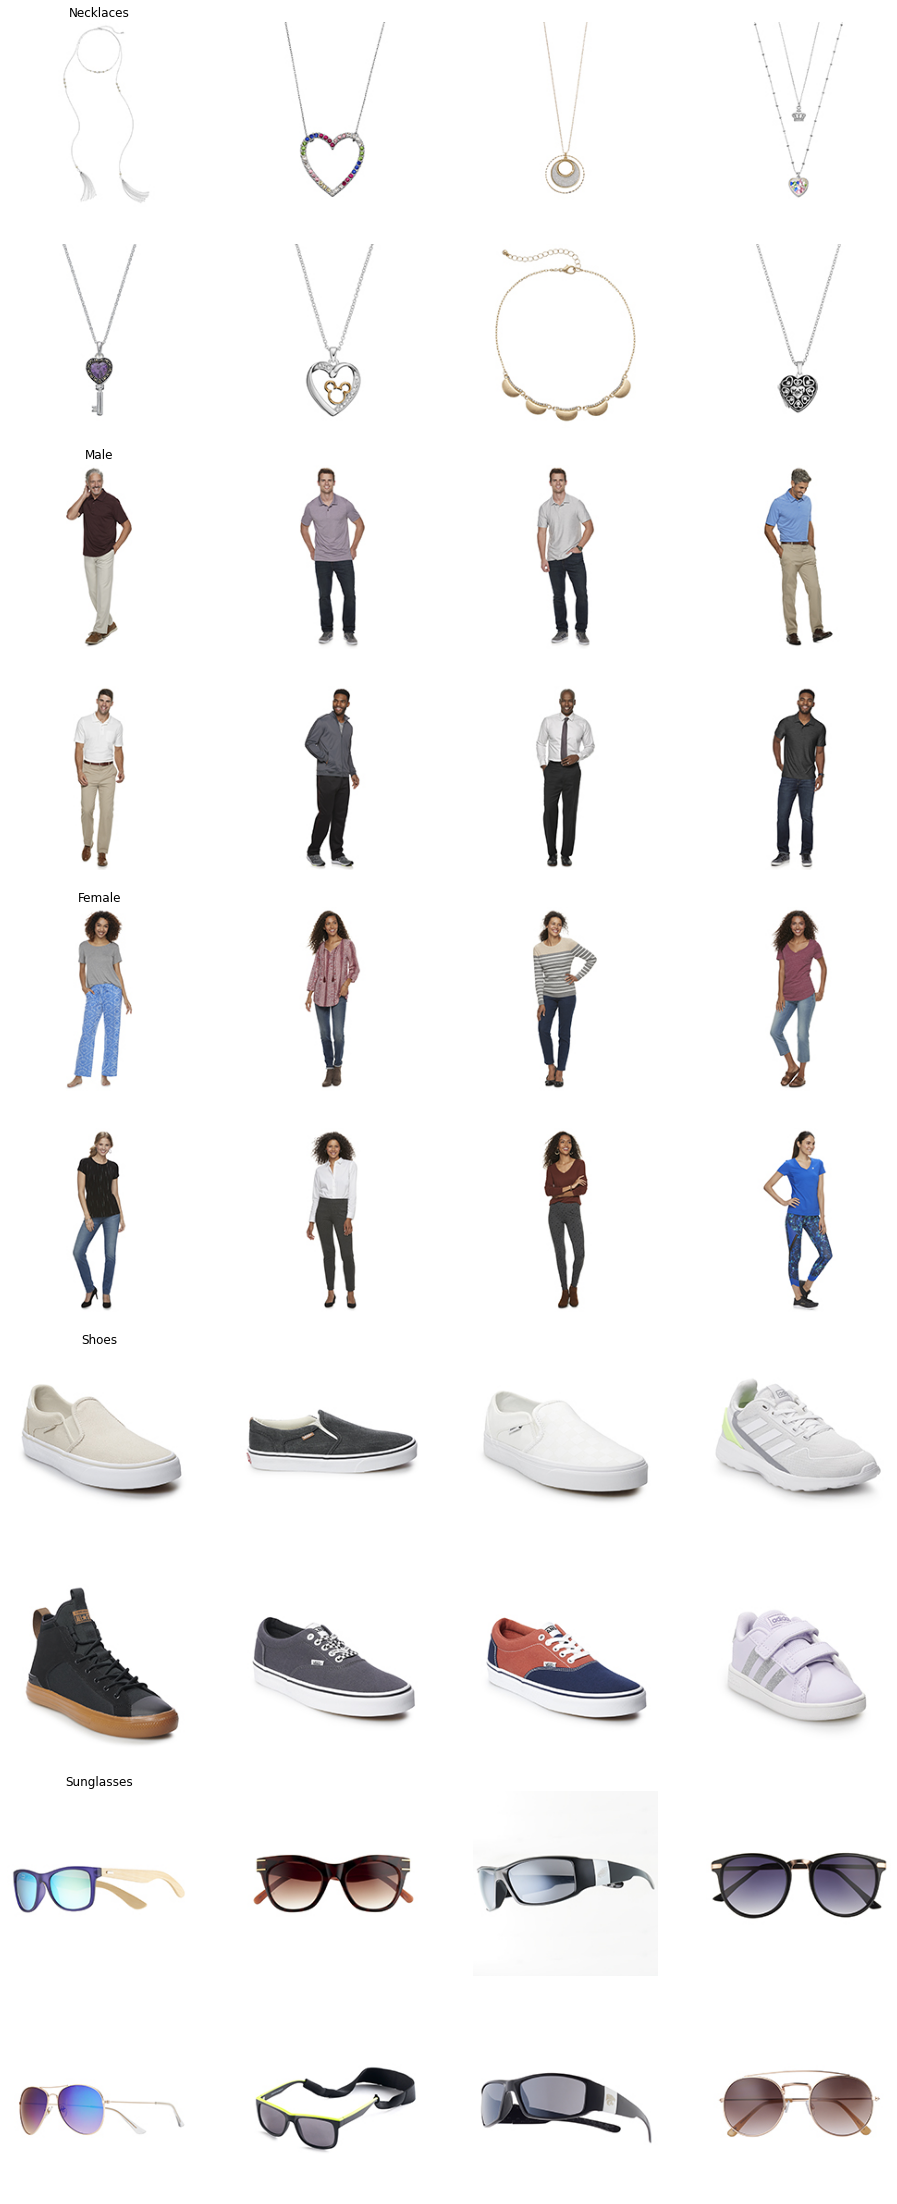

In [ ]:
nrows = 2 * (len(classnames))
ncols = 4 

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
random_pics = []
r_pic_titles = []

for d in train_dirs:
  for x in range (8):
    randomfile = random.choice(os.listdir(d))
    random_pics.append(os.path.join(d, randomfile))
    r_pic_titles.append(d[15:])

t = 8
for i, img_path in enumerate(random_pics):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  
  sp.axis('Off') # Don't show axes (or gridlines)

  if t % 8 == 0:
    sp.set_title(r_pic_titles[i])
  t+=1
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Model Setup

### Import the Inception model

We are going to use all the layers in the model except for the last fully connected layer as it is specific to the [ImageNet](https://http://image-net.org/challenges/LSVRC/) competition.

In [ ]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptionV3_model = InceptionV3(input_shape = (200, 200, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

87916544/87910968 [==============================] - 0s 0us/step


### Adding custom layers

In [ ]:
#Make all the pre-trained layers non-trainable
for layer in inceptionV3_model.layers:
  layer.trainable = False

# Flatten the output layer to 1 dimension
x = layers.Flatten()(inceptionV3_model.output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  

# Add a Sigmoid activation layer for binary, otherwise softmax.
if len(classnames)==2:
  x = layers.Dense  (1, activation='sigmoid')(x)

else:
  x = layers.Dense  (len(classnames), activation='softmax')(x)


model = Model(inceptionV3_model.input, x)

**Adam** with a learning rate of **0.0001**


In [ ]:
# Compile for the appropriate classification loss
if len(classnames)==2:
  model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])           
else:
  model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['acc'])


## Set up Generator to batch images

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1/255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1/255 )

# Flow training images in batches of 20 using train_datagen generator
if len(classnames)==2:
  train_generator = train_datagen.flow_from_directory(train_dir, 
                                                      batch_size = 20, 
                                                      class_mode = 'binary', 
                                                      target_size = (200, 200))
else:
  train_generator = train_datagen.flow_from_directory(train_dir, 
                                                      batch_size = 20,
                                                      class_mode = 'categorical', 
                                                      target_size = (200, 200))       

# Flow validation images in batches of 20 using test_datagen generator
if len(classnames)==2:
  validation_generator =  test_datagen.flow_from_directory( test_dir,
                                                            batch_size  = 20,
                                                            class_mode  = 'binary', 
                                                            target_size = (200, 200))
else:
  validation_generator =  test_datagen.flow_from_directory( test_dir,
                                                            batch_size  = 20,
                                                            class_mode = 'categorical', 
                                                            target_size = (200, 200))

Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


## Define a Callback to stop training once accuracy reaches 95%

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>=0.95):
      print("\nReached 95% accuracy so it's good to go!")
      self.model.stop_training = True

## Train the model

In [ ]:
callbacks = myCallback()
results = model.fit(train_generator, 
                    validation_data = validation_generator, 
                    steps_per_epoch = len(train_generator), 
                    epochs = 50, 
                    validation_steps = 20, 
                    verbose = 2, 
                    callbacks=[callbacks])

Epoch 1/50
200/200 - 43s - loss: 0.5390 - acc: 0.8808 - val_loss: 0.0840 - val_acc: 0.9675
Epoch 2/50
200/200 - 41s - loss: 0.2254 - acc: 0.9222 - val_loss: 0.0822 - val_acc: 0.9550
Epoch 3/50
200/200 - 41s - loss: 0.1544 - acc: 0.9417 - val_loss: 0.0496 - val_acc: 0.9850
Epoch 4/50
200/200 - 41s - loss: 0.1343 - acc: 0.9485 - val_loss: 0.0489 - val_acc: 0.9850
Epoch 5/50
200/200 - 41s - loss: 0.1370 - acc: 0.9457 - val_loss: 0.0762 - val_acc: 0.9750
Epoch 6/50

Reached 95% accuracy so it's good to go!
200/200 - 41s - loss: 0.1188 - acc: 0.9528 - val_loss: 0.0829 - val_acc: 0.9650


## Save the model

In [ ]:
model.save('/content/saved_model')
zipfolder('custom_model', '/content/saved_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/saved_model/assets


## Load the model

In [ ]:
model_zip = '/content/custom_model.zip'
zip_ref = zipfile.ZipFile(model_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/saved_model/')

# Use the Model to Test Images

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(200, 200))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x/255
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  if len(classnames) == 2:
    print(classes[0][0])
    print('{} is in class {}'.format(fn, classnames[round(classes[0][0])]))
  else:
    print(max(classes[0]))
    classidx = [i for i, j in enumerate(classes[0]) if j == max(classes[0])]
    print('{} is in class {}'.format(fn, classnames[classidx[0]]))

Saving Female01.jpg to Female01.jpg
Saving Female02.jpg to Female02.jpg
Saving Female03.jpg to Female03.jpg
Saving Male01.jpg to Male01.jpg
Saving Male02.jpg to Male02.jpg
Saving Male03.jpg to Male03.jpg
Saving Necklace01.jpg to Necklace01.jpg
Saving Necklace02.jpg to Necklace02.jpg
Saving Necklace03.jpg to Necklace03.jpg
Saving Shoe01.jpg to Shoe01.jpg
Saving Shoe02.jpg to Shoe02.jpg
Saving Shoe03.jpg to Shoe03.jpg
Saving Sunglasses01.jpg to Sunglasses01.jpg
Saving Sunglasses02.jpg to Sunglasses02.jpg
Saving Sunglasses03.jpg to Sunglasses03.jpg
0.9996854
Female01.jpg is in class Female
0.99913895
Female02.jpg is in class Female
0.9949994
Female03.jpg is in class Female
0.98932964
Male01.jpg is in class Male
0.9993222
Male02.jpg is in class Male
0.9593137
Male03.jpg is in class Male
1.0
Necklace01.jpg is in class Necklaces
1.0
Necklace02.jpg is in class Necklaces
1.0
Necklace03.jpg is in class Necklaces
1.0
Shoe01.jpg is in class Shoes
1.0
Shoe02.jpg is in class Shoes
1.0
Shoe03.jpg is

All test images have been correctly classified.